In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten,UpSampling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
from PIL import Image
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
!pip install pydot

In [ ]:
def build_generator(inputs, image_size):
    image_resize = image_size // 4
    kernel_size = 5

    model = Sequential()

    model.add(Dense(128 * 8 * 8, activation="relu", input_dim=100))
    model.add(Reshape((8, 8, 128)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2DTranspose(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img) 

In [ ]:
def build_discriminator(inputs):
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    x = inputs
    for filters in layer_filters:
            if filters == layer_filters[-1]:
                strides = 1
            else:
                strides = 2
    x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')

    discriminator.summary()
    return discriminator  

    

In [ ]:
def train(models, x_train, params):
    dis_loss = []
    adver_loss = []
    dis_acc = []
    adver_acc = []
    generator, discriminator, adversarial = models
    batch_size, latent_size, train_steps, model_name, image_size = params
    save_interval = 10
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    plot_input = np.random.uniform(-1.0, 1.0, size=[25, latent_size])
    train_size = x_train.shape[0]
    for i in range(train_steps):
        #noise_to_d = np.random.normal(0, 2/(i+1), (batch_size, image_size, image_size, 3))
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes] #+ noise_to_d
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        fake_images = generator.predict(noise)
        
        x = np.concatenate((real_images, fake_images))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        #one-sided label smoothing
        y[0:batch_size, :] = 0.9
        
        loss, acc = discriminator.train_on_batch(x, y)
        dis_loss.append(loss)
        dis_acc.append(acc)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])
        
        loss, acc = adversarial.train_on_batch(noise, y)
        adver_loss.append(loss)
        adver_acc.append(acc)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        
        if (i + 1) % save_interval == 0:
            plot_images(generator,noise_input=plot_input,show=False,step=(i + 1),model_name=model_name)
            
    #generator.save(model_name + ".h5") 
    plot_loss(dis_loss,adver_loss)
    plot_accuracy(dis_acc,adver_acc)

In [ ]:
from google.colab import files
def plot_images(generator,noise_input,show=False,step=0,model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(5, 5))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size,3])
        plt.imshow(image, cmap='gray')
        plt.axis('off')

    #plt.savefig(filename)
    plt.show()   

In [ ]:
def build_and_train_models():
    (x_train, _), (_, _) = cifar10.load_data()

    image_size = x_train.shape[1]

    x_train = x_train.astype('float32') / 255

    model_name = "dcgan_cifar"
    latent_size = 100
    batch_size = 64
    train_steps = 100
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 3)

    inputs = Input(shape=(image_size, image_size, 3), name='discriminator_input')
    discriminator = build_discriminator(inputs)
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])
    discriminator.summary()

    input_shape = (latent_size,)
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)

    discriminator.trainable = False

    adversarial = Model(inputs, 
                           discriminator(generator(inputs)),
                            name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                            optimizer=optimizer,
                            metrics=['accuracy'])
    adversarial.summary()


    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name,image_size)
    train(models, x_train, params)    

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 32, 32, 3)]      0         
 ayer)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       19456     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                                 
 flatten_4 (Flatten)         (None, 262144)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 262145    
                                                                 
 activation_16 (Activation)  (None, 1)                 0         
                                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 32, 32, 3)         1051267   
                                                                 
Total params: 1,051,267
Trainable params: 1,050,883
Non-trainable params: 384
_________________________________________________________________
Model: "dcgan_cifar"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_input (InputLayer)        [(None, 100)]             0         
                                                                 
 model_4 (Functional)        (None, 32, 32, 3)         1051267   
                                                                 
 discriminator (Functional

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

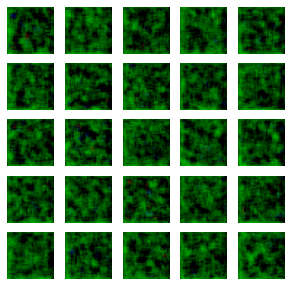

10: [discriminator loss: 0.175227, acc: 0.500000] [adversarial loss: 1.754409, acc: 0.156250]
11: [discriminator loss: 0.169873, acc: 0.500000] [adversarial loss: 1.278929, acc: 0.312500]
12: [discriminator loss: 0.174826, acc: 0.500000] [adversarial loss: 1.292485, acc: 0.203125]
13: [discriminator loss: 0.174914, acc: 0.500000] [adversarial loss: 0.718475, acc: 0.625000]
14: [discriminator loss: 0.185562, acc: 0.500000] [adversarial loss: 0.932033, acc: 0.390625]
15: [discriminator loss: 0.176350, acc: 0.500000] [adversarial loss: 0.551176, acc: 0.781250]
16: [discriminator loss: 0.180370, acc: 0.500000] [adversarial loss: 0.737839, acc: 0.562500]
17: [discriminator loss: 0.174338, acc: 0.500000] [adversarial loss: 0.415567, acc: 0.875000]
18: [discriminator loss: 0.175089, acc: 0.500000] [adversarial loss: 0.574362, acc: 0.718750]
19: [discriminator loss: 0.176563, acc: 0.500000] [adversarial loss: 0.353819, acc: 0.890625]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

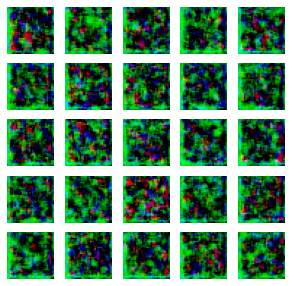

20: [discriminator loss: 0.185612, acc: 0.500000] [adversarial loss: 0.624115, acc: 0.671875]
21: [discriminator loss: 0.188042, acc: 0.500000] [adversarial loss: 0.482648, acc: 0.812500]
22: [discriminator loss: 0.195905, acc: 0.500000] [adversarial loss: 1.103206, acc: 0.203125]
23: [discriminator loss: 0.182513, acc: 0.500000] [adversarial loss: 0.893986, acc: 0.421875]
24: [discriminator loss: 0.186061, acc: 0.500000] [adversarial loss: 1.574475, acc: 0.000000]
25: [discriminator loss: 0.183878, acc: 0.500000] [adversarial loss: 1.434766, acc: 0.046875]
26: [discriminator loss: 0.184805, acc: 0.500000] [adversarial loss: 2.150164, acc: 0.000000]
27: [discriminator loss: 0.180575, acc: 0.500000] [adversarial loss: 1.775526, acc: 0.000000]
28: [discriminator loss: 0.190067, acc: 0.500000] [adversarial loss: 3.688300, acc: 0.000000]
29: [discriminator loss: 0.209812, acc: 0.500000] [adversarial loss: 1.395618, acc: 0.015625]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

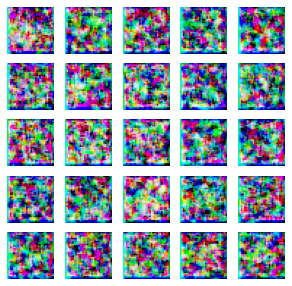

30: [discriminator loss: 0.278074, acc: 0.500000] [adversarial loss: 5.102826, acc: 0.000000]
31: [discriminator loss: 0.221626, acc: 0.500000] [adversarial loss: 3.307742, acc: 0.000000]
32: [discriminator loss: 0.189773, acc: 0.500000] [adversarial loss: 3.792537, acc: 0.000000]
33: [discriminator loss: 0.181517, acc: 0.500000] [adversarial loss: 3.821414, acc: 0.000000]
34: [discriminator loss: 0.182919, acc: 0.500000] [adversarial loss: 4.078732, acc: 0.000000]
35: [discriminator loss: 0.185403, acc: 0.500000] [adversarial loss: 4.203815, acc: 0.000000]
36: [discriminator loss: 0.181419, acc: 0.500000] [adversarial loss: 4.533236, acc: 0.000000]
37: [discriminator loss: 0.177949, acc: 0.500000] [adversarial loss: 4.537401, acc: 0.000000]
38: [discriminator loss: 0.180024, acc: 0.500000] [adversarial loss: 4.445833, acc: 0.000000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39: [discriminator loss: 0.178994, acc: 0.500000] [adversarial loss: 4.515412, acc: 0.000000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

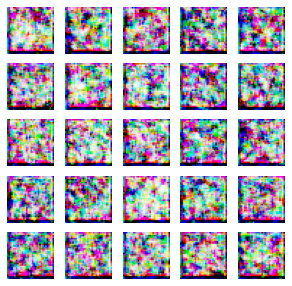

40: [discriminator loss: 0.175507, acc: 0.500000] [adversarial loss: 4.784506, acc: 0.000000]
41: [discriminator loss: 0.179488, acc: 0.500000] [adversarial loss: 4.187047, acc: 0.000000]
42: [discriminator loss: 0.180007, acc: 0.500000] [adversarial loss: 5.048640, acc: 0.000000]
43: [discriminator loss: 0.182190, acc: 0.500000] [adversarial loss: 4.384665, acc: 0.000000]
44: [discriminator loss: 0.180538, acc: 0.500000] [adversarial loss: 5.398014, acc: 0.000000]
45: [discriminator loss: 0.182970, acc: 0.500000] [adversarial loss: 4.166271, acc: 0.000000]
46: [discriminator loss: 0.192433, acc: 0.500000] [adversarial loss: 6.026417, acc: 0.000000]
47: [discriminator loss: 0.187927, acc: 0.500000] [adversarial loss: 3.489553, acc: 0.000000]
48: [discriminator loss: 0.208029, acc: 0.500000] [adversarial loss: 5.034502, acc: 0.000000]
49: [discriminator loss: 0.185879, acc: 0.500000] [adversarial loss: 3.613231, acc: 0.000000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

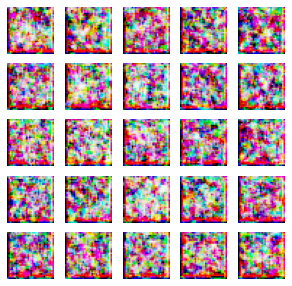

50: [discriminator loss: 0.188036, acc: 0.500000] [adversarial loss: 4.257786, acc: 0.000000]
51: [discriminator loss: 0.189047, acc: 0.500000] [adversarial loss: 3.648181, acc: 0.000000]
52: [discriminator loss: 0.189032, acc: 0.500000] [adversarial loss: 4.794673, acc: 0.000000]
53: [discriminator loss: 0.189865, acc: 0.500000] [adversarial loss: 2.816986, acc: 0.000000]
54: [discriminator loss: 0.206727, acc: 0.500000] [adversarial loss: 5.709810, acc: 0.000000]
55: [discriminator loss: 0.196654, acc: 0.500000] [adversarial loss: 3.310796, acc: 0.000000]
56: [discriminator loss: 0.195467, acc: 0.500000] [adversarial loss: 5.338935, acc: 0.000000]
57: [discriminator loss: 0.185391, acc: 0.500000] [adversarial loss: 4.230277, acc: 0.000000]
58: [discriminator loss: 0.180494, acc: 0.500000] [adversarial loss: 5.066101, acc: 0.000000]
59: [discriminator loss: 0.174400, acc: 0.500000] [adversarial loss: 4.778249, acc: 0.000000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

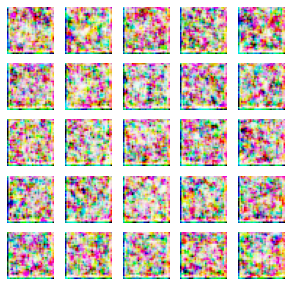

60: [discriminator loss: 0.179880, acc: 0.500000] [adversarial loss: 5.218388, acc: 0.000000]
61: [discriminator loss: 0.176598, acc: 0.500000] [adversarial loss: 4.795002, acc: 0.000000]
62: [discriminator loss: 0.179437, acc: 0.500000] [adversarial loss: 5.249113, acc: 0.000000]
63: [discriminator loss: 0.175006, acc: 0.500000] [adversarial loss: 5.060045, acc: 0.000000]
64: [discriminator loss: 0.174116, acc: 0.500000] [adversarial loss: 5.056110, acc: 0.000000]
65: [discriminator loss: 0.175339, acc: 0.500000] [adversarial loss: 6.024923, acc: 0.000000]
66: [discriminator loss: 0.178584, acc: 0.500000] [adversarial loss: 4.602077, acc: 0.000000]
67: [discriminator loss: 0.180729, acc: 0.500000] [adversarial loss: 6.450762, acc: 0.000000]
68: [discriminator loss: 0.183109, acc: 0.500000] [adversarial loss: 4.574739, acc: 0.000000]
69: [discriminator loss: 0.183165, acc: 0.500000] [adversarial loss: 6.045889, acc: 0.000000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

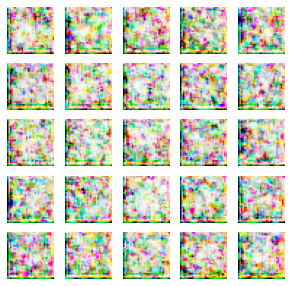

70: [discriminator loss: 0.178285, acc: 0.500000] [adversarial loss: 5.311748, acc: 0.000000]
71: [discriminator loss: 0.177515, acc: 0.500000] [adversarial loss: 5.692384, acc: 0.000000]
72: [discriminator loss: 0.170846, acc: 0.500000] [adversarial loss: 5.817271, acc: 0.000000]
73: [discriminator loss: 0.173709, acc: 0.500000] [adversarial loss: 5.624240, acc: 0.000000]
74: [discriminator loss: 0.173574, acc: 0.500000] [adversarial loss: 5.498764, acc: 0.000000]
75: [discriminator loss: 0.172297, acc: 0.500000] [adversarial loss: 5.547355, acc: 0.000000]
76: [discriminator loss: 0.176971, acc: 0.500000] [adversarial loss: 6.023216, acc: 0.000000]
77: [discriminator loss: 0.179182, acc: 0.500000] [adversarial loss: 4.815548, acc: 0.000000]
78: [discriminator loss: 0.181522, acc: 0.500000] [adversarial loss: 6.986850, acc: 0.000000]
79: [discriminator loss: 0.195080, acc: 0.500000] [adversarial loss: 5.180502, acc: 0.000000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

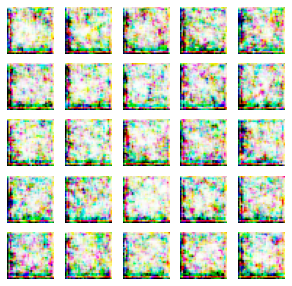

80: [discriminator loss: 0.185076, acc: 0.500000] [adversarial loss: 5.987383, acc: 0.000000]
81: [discriminator loss: 0.171649, acc: 0.500000] [adversarial loss: 5.978909, acc: 0.000000]
82: [discriminator loss: 0.172424, acc: 0.500000] [adversarial loss: 5.812780, acc: 0.000000]
83: [discriminator loss: 0.172297, acc: 0.500000] [adversarial loss: 5.863602, acc: 0.000000]
84: [discriminator loss: 0.173149, acc: 0.500000] [adversarial loss: 5.466880, acc: 0.000000]
85: [discriminator loss: 0.173951, acc: 0.500000] [adversarial loss: 6.215895, acc: 0.000000]
86: [discriminator loss: 0.168636, acc: 0.500000] [adversarial loss: 6.156463, acc: 0.000000]
87: [discriminator loss: 0.169884, acc: 0.500000] [adversarial loss: 5.914238, acc: 0.000000]
88: [discriminator loss: 0.175093, acc: 0.500000] [adversarial loss: 5.954726, acc: 0.000000]
89: [discriminator loss: 0.170706, acc: 0.500000] [adversarial loss: 6.016377, acc: 0.000000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

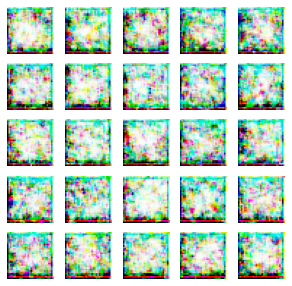

90: [discriminator loss: 0.175185, acc: 0.500000] [adversarial loss: 5.973062, acc: 0.000000]
91: [discriminator loss: 0.181466, acc: 0.500000] [adversarial loss: 5.081157, acc: 0.000000]
92: [discriminator loss: 0.177863, acc: 0.500000] [adversarial loss: 5.717953, acc: 0.000000]
93: [discriminator loss: 0.180296, acc: 0.500000] [adversarial loss: 3.953698, acc: 0.000000]
94: [discriminator loss: 0.184911, acc: 0.500000] [adversarial loss: 5.852902, acc: 0.000000]
95: [discriminator loss: 0.174978, acc: 0.500000] [adversarial loss: 4.872426, acc: 0.000000]
96: [discriminator loss: 0.174723, acc: 0.500000] [adversarial loss: 4.676723, acc: 0.000000]
97: [discriminator loss: 0.175081, acc: 0.500000] [adversarial loss: 4.909732, acc: 0.000000]
98: [discriminator loss: 0.174079, acc: 0.500000] [adversarial loss: 4.709938, acc: 0.000000]
99: [discriminator loss: 0.175071, acc: 0.500000] [adversarial loss: 5.342598, acc: 0.000000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

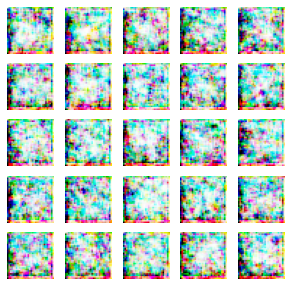

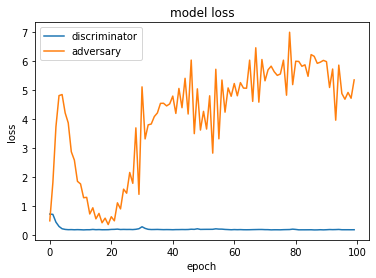

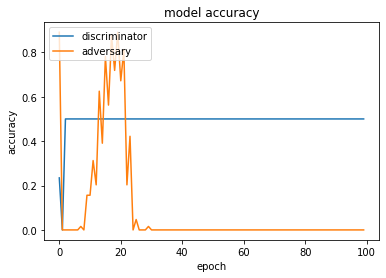

In [ ]:
build_and_train_models()

In [ ]:
#loss history for train
def plot_loss(dis_loss,gen_loss):
  plt.plot(dis_loss)
  plt.plot(gen_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['discriminator', 'adversary'], loc='upper left')
  plt.show()

In [ ]:
#accuracy plot for train
def plot_accuracy(dis_acc,gen_acc):
  plt.plot(dis_acc)
  plt.plot(gen_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['discriminator', 'adversary'], loc='upper left')
  plt.show()